In [1]:
import numpy as np
import pandas as pd
import thermo
import chemicals
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, FlashPureVLS, VaporPressure, PropertyCorrelationsPackage
from thermo import FlashVLN, ViscosityLiquidMixture, ViscosityGasMixture, SurfaceTensionMixture
import matplotlib.pyplot as plt
from thermo.interaction_parameters import IPDB
import pint

ureg = pint.UnitRegistry()

C:\Users\EricKim\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [1]:

def cas_to_name(cas):
    if not isinstance(cas, str):
        raise ValueError("Input must be a string")    
    return ChemicalConstantsPackage.constants_from_IDs([cas]).names[0]

def name_to_cas(name):
    if not isinstance(name, str):
        raise ValueError("Input must be a string")    
    return ChemicalConstantsPackage.constants_from_IDs([name]).CASs[0]
def F_to_R(F):
    return F + 459.67

def R_to_F(R):
    return R - 459.67

def C_to_K(C):
    return C + 273.15

def F_to_C(F):
    return (F - 32) * 5 / 9

def K_to_C(K):
    return K - 273.15

def gal_to_bbl(gal):
    return gal / 42

def bbl_to_gal(bbl):
    return bbl * 42

def psi_to_Pa(psi):
    return psi * 6894.745

def Pa_to_psi(pa):
    return pa / 6894.745

def F_to_K(F):
    return (F - 32) * 5/9 + 273.15

def K_to_F(K):
    return (K - 273.15) * 1.8 + 32

# Mixture (not good)

In [9]:
pure_comp = 'propane'
comp = dict([
    ('methane', 0.0), 
    ('propane', 0.4),
    ('hexane', .6),
    ('n-hexadecane', 0.00),
    ('water', 0.0),
])

total_comp = sum(comp.values())
if total_comp > 1:
    comp = {k: v / total_comp for k, v in comp.items()}
    
constants, properties = ChemicalConstantsPackage.from_IDs(comp.keys())
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')

eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=kijs)
gas = CEOSGas(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
liq = CEOSLiquid(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
flashN = FlashVLN(constants, properties, liquids=[liq, liq], gas=gas) # if dealing with water, fill [liq, liq] twice.

Ts_orig = np.arange(300, 310, 50)
Ts = [F_to_K(T) for T in Ts_orig]

Ps_orig = np.arange(3000, 4020, 3000)
Ps = [psi_to_Pa(P) for P in Ps_orig]

linears = []
logs = []
VFs = []
T_crits = []
for P in Ps:
    linears_isobar = []
    logs_isobar = []
    VFs_isobar = []
    for T in Ts:
        res = flashN.flash(T=T, P=P, zs=list(comp.values()))
    
        # liquid viscosity - LINEAR
        b = ViscosityLiquidMixture(ViscosityLiquids=res.ViscosityLiquids, correct_pressure_pure=True).calculate(
            T=T, P=P, zs=res.zs, ws=res.ws(), method='Logarithmic mixing, molar')
        b = ureg('%.15f pascal * second' % b).to('centipoise')._magnitude
        
        # liquid viscosity - LOGRATITHMIC
        b1 = ViscosityLiquidMixture(ViscosityLiquids=res.ViscosityLiquids, correct_pressure_pure=True).calculate(
            T=T, P=P, zs=res.zs, ws=res.ws(), method='LINEAR')
        b1 = ureg('%.15f pascal * second' % b1).to('centipoise')._magnitude
            
        linears_isobar.append(b)
        logs_isobar.append(b1)
        VFs_isobar.append(res.VF)
        
    linears.append(linears_isobar)
    logs.append(logs_isobar)
    VFs.append(VFs_isobar)

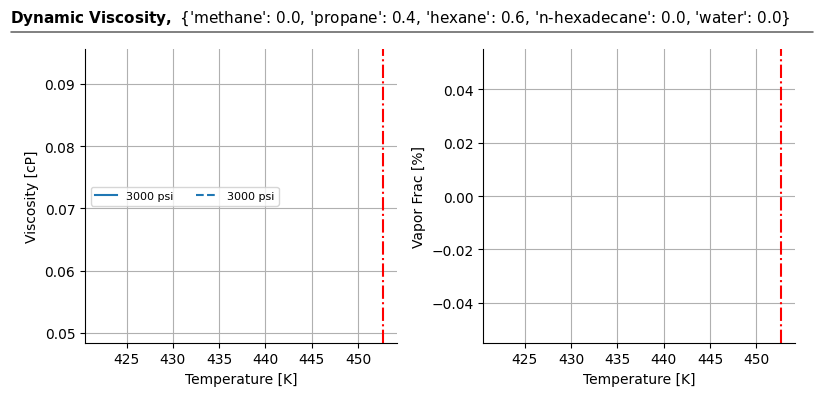

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax1 = axes[0]
ax2 = axes[1]

x = Ts_orig
x = [F_to_K(item) for item in x]
T_unit = 'K'

T_crit = res.pseudo_Tc()
#T_crit = K_to_C(res.pseudo_Tc())

for i, P in enumerate(Ps):
    line1, = ax1.plot(x, linears[i], label='%d psi' % Pa_to_psi(P))
    color = line1.get_color()
    
    ax1.plot(x, logs[i], label='%d psi' % Pa_to_psi(P), ls='--', color=color)
    ax2.plot(x, VFs[i], color=color)

for ax in axes:
    ax.set_xlabel('Temperature [%s]' % T_unit)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(x=T_crit, color='red', ls='-.')
    
    x_offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
    #y = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
    #ax.text(s='Crit. T = %d %s' % (T_crit, T_unit), y=y, x=T_crit - x_offset, va='top', ha='right', rotation=90, color='red')

ax1.set_ylabel('Viscosity [cP]')
ax2.set_ylabel('Vapor Frac [%]')

ax1.legend(ncol=2, fontsize=8)
    
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

comp = {k: round(v, 2) for k, v in comp.items()}

bold_txt = setbold('Dynamic Viscosity, ')
plain_txt = str(comp)
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

fig.tight_layout()

In [204]:
res.MW()

69.343464

In [162]:
res.pseudo_Tc()

452.648

In [163]:
K_to_F(res.pseudo_Tc())

355.0964000000001

In [164]:
Pa_to_psi(res.pseudo_Pc())

511.5403107729147

In [165]:
res.pseudo_Pc()

3526940.0

In [200]:
res.sigma()

In [187]:
.calculate(T=T, P=P, zs=res.zs, ws=res.ws(), method='Diguilio and Teja (1988)')

SyntaxError: invalid syntax (2308183384.py, line 1)

In [192]:
res.Tbs

[111.667205474, 231.03624791, 341.865616634, 559.90336533, 373.124295848]

In [193]:
type(res.Tbs)

list

# Pure Hexane

In [10]:
pure_comp = 'propane'
comp = dict([
    ('methane', 0.0), 
    ('propane', 0.00),
    ('hexane', 1.0),
    ('n-hexadecane', 0.00),
    ('water', 0.0),
])

total_comp = sum(comp.values())
if total_comp > 1:
    comp = {k: v / total_comp for k, v in comp.items()}
    
constants, properties = ChemicalConstantsPackage.from_IDs(comp.keys())
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')

eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=kijs)
gas = CEOSGas(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
liq = CEOSLiquid(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
flashN = FlashVLN(constants, properties, liquids=[liq, liq], gas=gas) # if dealing with water, fill [liq, liq] twice.

Ts_orig = np.arange(32, 500, 10)
Ts = [F_to_K(T) for T in Ts_orig]

Ps_orig = np.arange(14.7, 4020, 5000)
Ps = [psi_to_Pa(P) for P in Ps_orig]

linears = []
logs = []
VFs = []
for P in Ps:
    linears_isobar = []
    logs_isobar = []
    VFs_isobar = []
    for T in Ts:
        res = flashN.flash(T=T, P=P, zs=list(comp.values()))
    
        # liquid viscosity - LINEAR
        b = ViscosityLiquidMixture(ViscosityLiquids=res.ViscosityLiquids, correct_pressure_pure=True).calculate(
            T=T, P=P, zs=res.zs, ws=res.ws(), method='Logarithmic mixing, molar')
        b = ureg('%.15f pascal * second' % b).to('centipoise')._magnitude
        
        # liquid viscosity - LOGRATITHMIC
        b1 = ViscosityLiquidMixture(ViscosityLiquids=res.ViscosityLiquids, correct_pressure_pure=True).calculate(
            T=T, P=P, zs=res.zs, ws=res.ws(), method='LINEAR')
        b1 = ureg('%.15f pascal * second' % b1).to('centipoise')._magnitude
            
        linears_isobar.append(b)
        logs_isobar.append(b1)
        VFs_isobar.append(res.VF)
        
    linears.append(linears_isobar)
    logs.append(logs_isobar)
    VFs.append(VFs_isobar)

0.39391351987657997
1.045


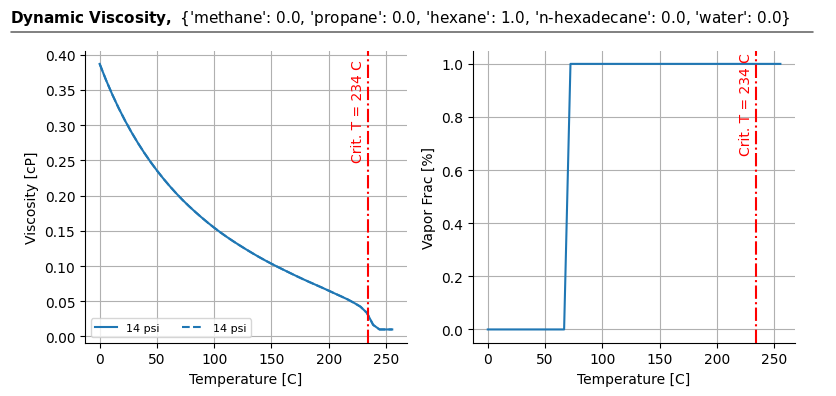

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax1 = axes[0]
ax2 = axes[1]

x = Ts_orig
x = [F_to_C(item) for item in x]
T_unit = 'C'

T_crit = res.pseudo_Tc()
T_crit = K_to_C(res.pseudo_Tc())

for i, P in enumerate(Ps):
    line1, = ax1.plot(x, linears[i], label='%d psi' % Pa_to_psi(P))
    color = line1.get_color()
    
    ax1.plot(x, logs[i], label='%d psi' % Pa_to_psi(P), ls='--', color=color)
    ax2.plot(x, VFs[i], color=color)

for ax in axes:
    ax.set_xlabel('Temperature [%s]' % T_unit)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(x=T_crit, color='red', ls='-.')
    
    x_offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
    y = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
    print(y)
    ax.text(s='Crit. T = %d %s' % (T_crit, T_unit), y=y, x=T_crit - x_offset, va='top', ha='right', rotation=90, color='red')

ax1.set_ylabel('Viscosity [cP]')
ax2.set_ylabel('Vapor Frac [%]')

ax1.legend(ncol=2, fontsize=8)
    
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('Dynamic Viscosity, ')
plain_txt = str(comp)
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

fig.tight_layout()

In [ ]:
res.